# MNIST With Pytorch: First steps
In this notebook, we aim to learn the basics of PyTorch for computer vision using the famous MNIST dataset—an image classification task involving handwritten digits (0 to 9). 

**We will not focus on architecture choices, but on framework implementation and concepts understanding**.

## The Data
To pull the data, we need to go through the following steps:
1. Download the dataset;
2. Divide in training and test data(for further validation);
3. Preprocessing;

### 1. Download the dataset
MNIST is alwready availabel with *torchvision.datasets*. It can be downloaded with the `datasets.MNIST` class. With this class, we can use a handy pipeline that downloads MNIST, saves it at a local directory, defines if it is for training or validation, and apply a preprocessing.

### 2. Divide in training and test data
It is necessary to divide the dataset into training part and test part to ensure that no test data interferes with training (causing data leakage). To do this, we can use the `DataLoader` class, passing the data, the batch size (for further training) and shuffle to training data. Shuffle is important to garantee that the model will not learn a sequential pattern of the dataset.

### 3. Preprocessing
With this dataset, we applied a pipeline with `ToTensor()` to transform image data to tensors with values between [0, 1], and `Normalize((0,), (1,))` to normalize with **mean=0** and **std=1** (a commum practice to speed up traning).

In [1]:

# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Defines transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

# Download and transform
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Visualizing
We can use matplotlib to visualize some example images.

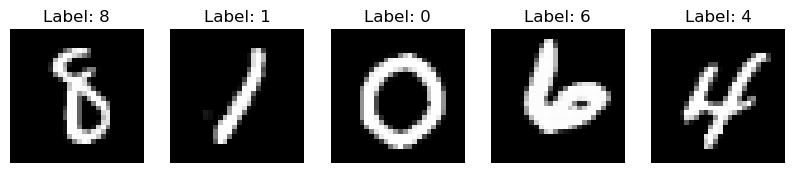

In [2]:
import matplotlib.pyplot as plt

# Function to plot images with its lables
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Get a batch of images from the training data loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 5 images with its labels
show_images(images[:5], labels[:5])

In [3]:
print(images.shape)

torch.Size([64, 1, 28, 28])


## Defining a Neural Network
In Pytorch, a model (in our case a neural network) is defined by a class that inherits `nn.Module`. This class works like a blueprint for a pytorch model and requires at least `__init__()` and `foward()` method implementations.

### The constructor
In `__init__()` we can define the layers of our model. In this example, we used the following architecture:

- **1º Layer:** A fully connected layer (defined by `nn.Linear` class) for feature extraction **[784 -> 128]**;<br>
- **ReLU:** A activation function for non-linearity **[128 -> 128]**;<br>
- **2º Layer:** A fully connected layer for final classess features **[128 -> 10]**; <br>
- **Softmax:** A activation function to classify the image **[10 -> 10]**.

### foward()
This method defines the execution order of a inference, from raw image to softmax classification.

In [4]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Input must be a flat tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

model = SimpleNN()

## Loss Function and Optmizer
At this section we define
- Negative Log-Likelihood Loss as our loss function;
- Stochastic Gradient Descent as our optmizer

`optim.SGD()` receives 3 parameters:
- `model.parameters()`, defines that every trainable parameters will be optmized;
- `lr=0.01`, defines that the learning step size will be 0.01 (big=-convertion; small=slow);
- `momentum=0.9`, defines how much previous gradients affects a current step (0->1 | 0% to 100%). It is important to not stop at a local minimum

In [5]:
import torch.optim as optim

criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training 
For each epoch, a training go through foward pass making infereces, calculates the errors with the loss functions, and adjust itself through backward pass

- `optmizer.zero_grad()`: resets the gradients to zero (to avoid accumulation from previous steps);
- `model(images)`: generates predictions from the input images;
- `criterion(outputs, labels)`: computes the loss by comparing predictions with ground truth labels;
- `loss.backward()`: computes gradients via backpropagation;
- `optmizer.step()`: updates model weights based on the computed gradients;

In [6]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print("Training complete!")

Epoch 1, Loss: 0.47106180781685214
Epoch 2, Loss: 0.2348487160678929
Epoch 3, Loss: 0.17474408296824517
Epoch 4, Loss: 0.13803085089841885
Epoch 5, Loss: 0.11493414242678424
Training complete!


# Validation

For each batch of test data, uses the model to predicts a class. The prediction is the highest probability at the last layer (result of softmax activation), and is compared to the annotation. 

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 96.72%
